In [1]:
import pandas as pd
import numpy as np
import sqlite3
import shutil
import ipynbname
import datetime
import sys
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MultiLabelBinarizer
from sklearn.impute import SimpleImputer

from pytorch_tabular import TabularModel
from pytorch_tabular.models import NodeConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig,
)


from Process_Function import RareCategoryTransformer
from Visualization_function import *
from LG_Aimers_6th.cal_auc import calculate_auc
import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [2]:
train_path = '../data/custom_train_1.csv'
test_path = '../data/custom_test_1.csv'
sample_path = '../data/sample_submission.csv'

# train_path = '../data/train.csv'
# test_path = '../data/test.csv'
# sample_path = '../data/sample_submission.csv'

# ÌïôÏäµ/ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train = pd.read_csv(train_path).drop(columns=['ID'])
test = pd.read_csv(test_path).drop(columns=['ID'])

print(train.shape, test.shape)

train['ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä'].value_counts(normalize=True)

(205080, 68) (51271, 67)


ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä
0    0.741652
1    0.258348
Name: proportion, dtype: float64

In [3]:
train

ÏãúÏà† ÏãúÍ∏∞ ÏΩîÎìú ÏãúÏà† ÎãπÏãú ÎÇòÏù¥  ÏûÑÏã† ÏãúÎèÑ ÎòêÎäî ÎßàÏßÄÎßâ ÏûÑÏã† Í≤ΩÍ≥º Ïó∞Ïàò ÏãúÏà† Ïú†Ìòï ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï  Î∞∞ÎûÄ ÏûêÍ∑π Ïó¨Î∂Ä  \
0        TRDQAZ  Îßå43-44ÏÑ∏                    NaN   IVF      IVF         0   
1        TRJXFG  Îßå35-37ÏÑ∏                    NaN   IVF  Unknown         0   
2        TRXQMD  Îßå18-34ÏÑ∏                    NaN    DI      IUI         0   
3        TRDQAZ  Îßå35-37ÏÑ∏                    NaN   IVF      IVF         1   
4        TRVNRY  Îßå18-34ÏÑ∏                    NaN   IVF      IVF         1   
...         ...      ...                    ...   ...      ...       ...   
205075   TRXQMD  Îßå18-34ÏÑ∏                    NaN   IVF  Unknown         0   
205076   TRYBLT  Îßå18-34ÏÑ∏                    NaN   IVF      IVF         1   
205077   TRCMWS  Îßå18-34ÏÑ∏                    NaN   IVF  Unknown         0   
205078   TRYBLT  Îßå18-34ÏÑ∏                    NaN   IVF      IVF         1   
205079   TRVNRY  Îßå18-34ÏÑ∏                    NaN   IVF     ICSI         1   

          Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï  Îã®Ïùº Î∞∞ÏïÑ Ïù¥Ïãù Ïó¨Î∂Ä  Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ Í≤ÄÏÇ¨ ÏÇ¨Ïö© Ïó¨Î∂Ä  Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ ÏßÑÎã® ÏÇ¨Ïö© Ïó¨Î∂Ä  ...  \
0           Ïïå Ïàò ÏóÜÏùå          0.0               NaN               0.0  ...   
1           Ïïå Ïàò ÏóÜÏùå          1.0               NaN               0.0  ...   
2           Ïïå Ïàò ÏóÜÏùå          NaN               NaN               NaN  ...   
3       Í∏∞Î°ùÎêòÏßÄ ÏïäÏùÄ ÏãúÌñâ          0.0               NaN               0.0  ...   
4       Í∏∞Î°ùÎêòÏßÄ ÏïäÏùÄ ÏãúÌñâ          1.0               NaN               0.0  ...   
...            ...          ...               ...               ...  ...   
205075      Ïïå Ïàò ÏóÜÏùå          0.0               NaN               0.0  ...   
205076  Í∏∞Î°ùÎêòÏßÄ ÏïäÏùÄ ÏãúÌñâ          0.0               NaN               0.0  ...   
205077      Ïïå Ïàò ÏóÜÏùå          0.0               NaN               0.0  ...   
205078  Í∏∞Î°ùÎêòÏßÄ ÏïäÏùÄ ÏãúÌñâ          1.0               NaN               0.0  ...   
205079  Í∏∞Î°ùÎêòÏßÄ ÏïäÏùÄ ÏãúÌñâ          0.0               NaN               0.0  ...   

        Í∏∞Ï¶ù Î∞∞ÏïÑ ÏÇ¨Ïö© Ïó¨Î∂Ä  ÎåÄÎ¶¨Î™® Ïó¨Î∂Ä  PGD ÏãúÏà† Ïó¨Î∂Ä  PGS ÏãúÏà† Ïó¨Î∂Ä  ÎÇúÏûê Ï±ÑÏ∑® Í≤ΩÍ≥ºÏùº  ÎÇúÏûê Ìï¥Îèô Í≤ΩÍ≥ºÏùº  \
0               0.0     0.0        NaN        NaN        NaN        NaN   
1               0.0     1.0        NaN        NaN        NaN        NaN   
2               NaN     NaN        NaN        NaN        NaN        NaN   
3               0.0     0.0        NaN        NaN        0.0        NaN   
4               0.0     0.0        NaN        NaN        0.0        NaN   
...             ...     ...        ...        ...        ...        ...   
205075          0.0     0.0        NaN        NaN        NaN        NaN   
205076          0.0     0.0        NaN        NaN        0.0        NaN   
205077          0.0     0.0        NaN        NaN        NaN        NaN   
205078          0.0     0.0        NaN        NaN        0.0        NaN   
205079          0.0     0.0        NaN        NaN        0.0        NaN   

        ÎÇúÏûê ÌòºÌï© Í≤ΩÍ≥ºÏùº  Î∞∞ÏïÑ Ïù¥Ïãù Í≤ΩÍ≥ºÏùº  Î∞∞ÏïÑ Ìï¥Îèô Í≤ΩÍ≥ºÏùº  ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä  
0             NaN        0.0        0.0         0  
1             NaN        0.0        0.0         1  
2             NaN        NaN        NaN         0  
3             0.0        5.0        NaN         0  
4             0.0        3.0        NaN         0  
...           ...        ...        ...       ...  
205075        NaN        1.0        0.0         0  
205076        0.0        3.0        NaN         0  
205077        NaN        0.0        0.0         0  
205078        0.0        5.0        NaN         1  
205079        0.0        2.0        NaN         1  

[205080 rows x 68 columns]

In [6]:
def drop_columns(df):
    cols = [
        'Î∂àÏûÑ ÏõêÏù∏ - Ïó¨ÏÑ± ÏöîÏù∏',  # Í≥†Ïú†Í∞í 1
        'Î∂àÏûÑ ÏõêÏù∏ - Ï†ïÏûê Î©¥Ïó≠ÌïôÏ†Å ÏöîÏù∏',  # train, test Î™®Îëê '1'Ïù∏ Îç∞Ïù¥ÌÑ∞ 1Í∞ú >> Ïã†Î¢∞Ìï† Ïàò ÏóÜÏùå
        'ÎÇúÏûê Ìï¥Îèô Í≤ΩÍ≥ºÏùº',
    ]
    df = df.drop(cols, axis=1)
    return df

def ÌäπÏ†ïÏãúÏà†Ïú†Ìòï(train, test):
    def categorize_procedure(proc):
        tokens = [token.strip() for token in proc.split(",") if token.strip() and not token.strip().isdigit()]
        # Ïö∞ÏÑ†ÏàúÏúÑÏóê Îî∞Î•∏ Î≤îÏ£ºÌôî
        if tokens.count("Unknown") >= 1:
            return "Unknown"
        if tokens.count("AH") >= 1:
            return "AH"
        if tokens.count("BLASTOCYST") >= 1:
            return "BLASTOCYST"
        if tokens.count("ICSI") >= 2 or tokens.count("IVF") >= 2:
            return "2ICSI_2IVF"
        if tokens.count("IVF") >= 1 and tokens.count("ICSI") >= 1:
            return "IVF_ICSI"
        if tokens == "ICSI":
            return "ICSI"
        if tokens == "IVF":
            return "IVF"
        return ",".join(tokens) if tokens else None

    for df in [train, test]:
        df['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'] = df['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].str.replace(" / ", ",")
        df['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'] = df['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].str.replace(":", ",")
        df['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'] = df['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].str.replace(" ", "")

    counts = train['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].value_counts()
    allowed_categories = counts[counts >= 100].index.tolist()

    # allowed_categoriesÏóê ÏÜçÌïòÏßÄ ÏïäÎäî Í∞íÏùÄ "Unknown"ÏúºÎ°ú ÎåÄÏ≤¥
    train.loc[~train['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].isin(allowed_categories), 'ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'] = "Unknown"
    test.loc[~test['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].isin(allowed_categories), 'ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'] = "Unknown"

    train['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'] = train['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].apply(categorize_procedure)
    test['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'] = test['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].apply(categorize_procedure)

    train['ÏãúÏà†Ïú†Ìòï_ÌÜµÌï©'] = train['ÏãúÏà† Ïú†Ìòï'].astype(str) + '_' + train['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].astype(str)
    test['ÏãúÏà†Ïú†Ìòï_ÌÜµÌï©'] = test['ÏãúÏà† Ïú†Ìòï'].astype(str) + '_' + test['ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï'].astype(str)

    drop_cols = ['ÏãúÏà† Ïú†Ìòï', 'ÌäπÏ†ï ÏãúÏà† Ïú†Ìòï']
    train = train.drop(drop_cols, axis=1)
    test = test.drop(drop_cols, axis=1)

    return train, test

def ÏãúÏà†ÌöüÏàò(df_train):
    for col in [col for col in df_train.columns if 'ÌöüÏàò' in col]:
        df_train[col] = df_train[col].replace({'6Ìöå Ïù¥ÏÉÅ':'6Ìöå'})
        df_train[col] = df_train[col].str[0].astype(int)
    df_train['ÏãúÏà†_ÏûÑÏã†'] = df_train['Ï¥ù ÏûÑÏã† ÌöüÏàò'] - df_train['Ï¥ù ÏãúÏà† ÌöüÏàò']
    df_train = df_train.drop('Ï¥ù ÏãúÏà† ÌöüÏàò', axis=1)
    return df_train

def Î∞∞ÎûÄÏú†ÎèÑÏú†Ìòï(df_train, df_test):
    mapping = {
        'Í∏∞Î°ùÎêòÏßÄ ÏïäÏùÄ ÏãúÌñâ': 1,
        'Ïïå Ïàò ÏóÜÏùå': 0,
        'ÏÑ∏Ìä∏Î°úÌÉÄÏù¥Îìú (ÏñµÏ†úÏ†ú)': 0,
        'ÏÉùÏãùÏÑ† ÏûêÍ∑π Ìò∏Î•¥Î™¨': 0,
    }
    df_train['Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï'] = df_train['Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï'].replace(mapping)
    df_test['Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï'] = df_test['Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï'].replace(mapping)
    return df_train, df_test

def ÎÇúÏûêÍ∏∞Ï¶ùÏûêÎÇòÏù¥(df_train, df_test):
    mapping = {
        'Îßå20ÏÑ∏ Ïù¥Ìïò': 20,
        'Îßå21-25ÏÑ∏': 25,
        'Îßå26-30ÏÑ∏': 30,
        'Îßå31-35ÏÑ∏': 35,
        'Ïïå Ïàò ÏóÜÏùå': 20,  # Îßå20ÏÑ∏ Ïù¥ÌïòÏôÄ ÎèôÏùºÌïòÍ≤å Ï≤òÎ¶¨
    }
    df_train['ÎÇúÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥'] = df_train['ÎÇúÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥'].replace(mapping)
    df_test['ÎÇúÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥'] = df_test['ÎÇúÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥'].replace(mapping)
    return df_train, df_test

def Î∞∞ÏïÑÏÉùÏÑ±Ï£ºÏöîÏù¥Ïú†(df_train, df_test):
    df_train['Î∞∞ÏïÑ ÏÉùÏÑ± Ï£ºÏöî Ïù¥Ïú†'] = df_train['Î∞∞ÏïÑ ÏÉùÏÑ± Ï£ºÏöî Ïù¥Ïú†'].fillna('DI')
    df_test['Î∞∞ÏïÑ ÏÉùÏÑ± Ï£ºÏöî Ïù¥Ïú†'] = df_test['Î∞∞ÏïÑ ÏÉùÏÑ± Ï£ºÏöî Ïù¥Ïú†'].fillna('DI')

    df_train['Î∞∞ÏïÑ ÏÉùÏÑ± Ïù¥Ïú† Î¶¨Ïä§Ìä∏'] = df_train['Î∞∞ÏïÑ ÏÉùÏÑ± Ï£ºÏöî Ïù¥Ïú†'].apply(lambda x: [reason.strip() for reason in x.split(',')])
    df_test['Î∞∞ÏïÑ ÏÉùÏÑ± Ïù¥Ïú† Î¶¨Ïä§Ìä∏'] = df_test['Î∞∞ÏïÑ ÏÉùÏÑ± Ï£ºÏöî Ïù¥Ïú†'].apply(lambda x: [reason.strip() for reason in x.split(',')])

    mlb = MultiLabelBinarizer()
    train_one_hot = pd.DataFrame(
        mlb.fit_transform(df_train['Î∞∞ÏïÑ ÏÉùÏÑ± Ïù¥Ïú† Î¶¨Ïä§Ìä∏']),
        columns=mlb.classes_,
        index=df_train.index
    )
    train_one_hot.columns = ['Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_' + col for col in train_one_hot.columns]

    test_one_hot = pd.DataFrame(
        mlb.transform(df_test['Î∞∞ÏïÑ ÏÉùÏÑ± Ïù¥Ïú† Î¶¨Ïä§Ìä∏']),
        columns=mlb.classes_,
        index=df_test.index
    )
    test_one_hot.columns = ['Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_' + col for col in test_one_hot.columns]

    df_train = pd.concat([df_train, train_one_hot], axis=1)
    df_test = pd.concat([df_test, test_one_hot], axis=1)

    cols_to_drop = [
        'Î∞∞ÏïÑ ÏÉùÏÑ± Ï£ºÏöî Ïù¥Ïú†',
        'Î∞∞ÏïÑ ÏÉùÏÑ± Ïù¥Ïú† Î¶¨Ïä§Ìä∏',
        'Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_Ïó∞Íµ¨Ïö©',
        'Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_DI'
    ]
    df_train = df_train.drop(cols_to_drop, axis=1, errors='ignore')
    df_test = df_test.drop(cols_to_drop, axis=1, errors='ignore')

    cols = ['Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_Í∏∞Ï¶ùÏö©',
            'Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_ÎÇúÏûê Ï†ÄÏû•Ïö©',
            'Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_Î∞∞ÏïÑ Ï†ÄÏû•Ïö©',
            'Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_ÌòÑÏû¨ ÏãúÏà†Ïö©']

    df_train[cols] = df_train[cols].div(df_train[cols].sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    df_test[cols] = df_test[cols].div(df_test[cols].sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    return df_train, df_test

def Îã®ÏùºÎ∞∞ÏïÑÏù¥ÏãùÏó¨Î∂Ä(df_train, df_val):
    df_train['Îã®Ïùº Î∞∞ÏïÑ Ïù¥Ïãù Ïó¨Î∂Ä'] = df_train['Îã®Ïùº Î∞∞ÏïÑ Ïù¥Ïãù Ïó¨Î∂Ä'].fillna(0)
    df_val['Îã®Ïùº Î∞∞ÏïÑ Ïù¥Ïãù Ïó¨Î∂Ä'] = df_val['Îã®Ïùº Î∞∞ÏïÑ Ïù¥Ïãù Ïó¨Î∂Ä'].fillna(0)
    return df_train, df_val


def Í∏∞Ï¶ùÏûêÏ†ïÏûêÏôÄÌòºÌï©ÎêúÎÇúÏûêÏàò(df_train, df_test):
    df_train["Í∏∞Ï¶ùÏûê Ï†ïÏûêÏôÄ ÌòºÌï©Îêú ÎÇúÏûê Ïàò"] = df_train["Í∏∞Ï¶ùÏûê Ï†ïÏûêÏôÄ ÌòºÌï©Îêú ÎÇúÏûê Ïàò"].fillna(2)
    df_test["Í∏∞Ï¶ùÏûê Ï†ïÏûêÏôÄ ÌòºÌï©Îêú ÎÇúÏûê Ïàò"] = df_test["Í∏∞Ï¶ùÏûê Ï†ïÏûêÏôÄ ÌòºÌï©Îêú ÎÇúÏûê Ïàò"].fillna(2)
    return df_train, df_test

def type_to_category(train, test, cols):
    train[cols] = train[cols].astype('category')
    test[cols] = test[cols].astype('category')
    return train, test

def impute_nan(train, test):
    cols_to_impute = [
        'ÏûÑÏã† ÏãúÎèÑ ÎòêÎäî ÎßàÏßÄÎßâ ÏûÑÏã† Í≤ΩÍ≥º Ïó∞Ïàò', # DI, IVFÎûë Í¥ÄÎ†® X
    ]
    imputer = SimpleImputer(strategy='mean')
    train[cols_to_impute] = imputer.fit_transform(train[cols_to_impute])
    test[cols_to_impute] = imputer.transform(test[cols_to_impute])

    cols_to_impute = [
        'ÎÇúÏûê Ï±ÑÏ∑® Í≤ΩÍ≥ºÏùº',
        'ÎÇúÏûê ÌòºÌï© Í≤ΩÍ≥ºÏùº',
        'Î∞∞ÏïÑ Ïù¥Ïãù Í≤ΩÍ≥ºÏùº',
        'Î∞∞ÏïÑ Ìï¥Îèô Í≤ΩÍ≥ºÏùº',

        'Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ Í≤ÄÏÇ¨ ÏÇ¨Ïö© Ïó¨Î∂Ä',
        'PGD ÏãúÏà† Ïó¨Î∂Ä',
        'PGS ÏãúÏà† Ïó¨Î∂Ä',

        ### DI only
        'Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ ÏßÑÎã® ÏÇ¨Ïö© Ïó¨Î∂Ä',
        'Ï¥ù ÏÉùÏÑ± Î∞∞ÏïÑ Ïàò',
        'ÎØ∏ÏÑ∏Ï£ºÏûÖÎêú ÎÇúÏûê Ïàò',
        'ÎØ∏ÏÑ∏Ï£ºÏûÖÏóêÏÑú ÏÉùÏÑ±Îêú Î∞∞ÏïÑ Ïàò',
        'Ïù¥ÏãùÎêú Î∞∞ÏïÑ Ïàò',
        'ÎØ∏ÏÑ∏Ï£ºÏûÖ Î∞∞ÏïÑ Ïù¥Ïãù Ïàò',
        'Ï†ÄÏû•Îêú Î∞∞ÏïÑ Ïàò',
        'ÎØ∏ÏÑ∏Ï£ºÏûÖ ÌõÑ Ï†ÄÏû•Îêú Î∞∞ÏïÑ Ïàò',
        'Ìï¥ÎèôÎêú Î∞∞ÏïÑ Ïàò',
        'Ìï¥Îèô ÎÇúÏûê Ïàò',
        'ÏàòÏßëÎêú Ïã†ÏÑ† ÎÇúÏûê Ïàò',
        'Ï†ÄÏû•Îêú Ïã†ÏÑ† ÎÇúÏûê Ïàò',
        'ÌòºÌï©Îêú ÎÇúÏûê Ïàò',
        'ÌååÌä∏ÎÑà Ï†ïÏûêÏôÄ ÌòºÌï©Îêú ÎÇúÏûê Ïàò',
        'Í∏∞Ï¶ùÏûê Ï†ïÏûêÏôÄ ÌòºÌï©Îêú ÎÇúÏûê Ïàò',
        'ÎèôÍ≤∞ Î∞∞ÏïÑ ÏÇ¨Ïö© Ïó¨Î∂Ä',
        'Ïã†ÏÑ† Î∞∞ÏïÑ ÏÇ¨Ïö© Ïó¨Î∂Ä',
        'Í∏∞Ï¶ù Î∞∞ÏïÑ ÏÇ¨Ïö© Ïó¨Î∂Ä',
        'ÎåÄÎ¶¨Î™® Ïó¨Î∂Ä',
        ### DI
    ]
    train[cols_to_impute] = train[cols_to_impute].fillna(0)
    test[cols_to_impute] = test[cols_to_impute].fillna(0)

    return train, test

def num_feature_scailing(train, test):
    # cols_to_divide = [
    #     'Ïó∞Í∞Ñ ÏÜåÎìù',
    #     'ÏµúÎåÄ Ïã†Ïö©ÌïúÎèÑ',
    #     'ÌòÑÏû¨ ÎåÄÏ∂ú ÏûîÏï°',
    #     'ÌòÑÏû¨ ÎØ∏ÏÉÅÌôò Ïã†Ïö©Ïï°',
    #     'Ïõî ÏÉÅÌôò Î∂ÄÏ±ÑÏï°',
    # ]
    # train[cols_to_divide] = train[cols_to_divide] / 100000
    # test[cols_to_divide] = test[cols_to_divide] / 100000

    cols_to_log = [
        'Ï¥ù ÏÉùÏÑ± Î∞∞ÏïÑ Ïàò',
    ]
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    train[cols_to_log] = log_transformer.fit_transform(train[cols_to_log])
    test[cols_to_log] = log_transformer.transform(test[cols_to_log])

    # numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
    # cat_cols = [col for col in train.columns if pd.api.types.is_categorical_dtype(train[col])]
    # cols_to_scale = [
    #     col for col in numeric_cols
    #     if col not in cat_cols and col != 'ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä'
    # ]
    # scaler = StandardScaler()
    # train[cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
    # test[cols_to_scale] = scaler.transform(test[cols_to_scale])

    return train, test

def all_process(train, val):
    # Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨ Îã®Í≥Ñ
    train, val = drop_columns(train), drop_columns(val)
    train, val = ÌäπÏ†ïÏãúÏà†Ïú†Ìòï(train, val)
    train, val = ÏãúÏà†ÌöüÏàò(train), ÏãúÏà†ÌöüÏàò(val)

    cols_to_encoding = [
        "ÏãúÏà† ÏãúÍ∏∞ ÏΩîÎìú",
        "ÏãúÏà† ÎãπÏãú ÎÇòÏù¥",
        "Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï",
        # "ÌÅ¥Î¶¨Îãâ ÎÇ¥ Ï¥ù ÏãúÏà† ÌöüÏàò",
        # "IVF ÏãúÏà† ÌöüÏàò",
        # "DI ÏãúÏà† ÌöüÏàò",
        # "Ï¥ù ÏûÑÏã† ÌöüÏàò",
        # "IVF ÏûÑÏã† ÌöüÏàò",
        # "DI ÏûÑÏã† ÌöüÏàò",
        # "Ï¥ù Ï∂úÏÇ∞ ÌöüÏàò",
        # "IVF Ï∂úÏÇ∞ ÌöüÏàò",
        # "DI Ï∂úÏÇ∞ ÌöüÏàò",
        "ÎÇúÏûê Ï∂úÏ≤ò",
        "Ï†ïÏûê Ï∂úÏ≤ò",
        "ÎÇúÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥",
        "Ï†ïÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥",
        'ÏãúÏà†Ïú†Ìòï_ÌÜµÌï©',
    ]
    train, val = type_to_category(train, val, cols=cols_to_encoding)

    train, val = Îã®ÏùºÎ∞∞ÏïÑÏù¥ÏãùÏó¨Î∂Ä(train, val)
    train, val = Î∞∞ÎûÄÏú†ÎèÑÏú†Ìòï(train, val)
    train, val = Î∞∞ÏïÑÏÉùÏÑ±Ï£ºÏöîÏù¥Ïú†(train, val)

    train, val = impute_nan(train, val)
    train, val = num_feature_scailing(train, val)

    return train, val

train = pd.read_csv(train_path).drop(columns=['ID'])
test = pd.read_csv(test_path).drop(columns=['ID'])

train, test = all_process(train, test)

print(train.shape, test.shape)

(205080, 67) (51271, 66)


In [7]:
train

ÏãúÏà† ÏãúÍ∏∞ ÏΩîÎìú ÏãúÏà† ÎãπÏãú ÎÇòÏù¥  ÏûÑÏã† ÏãúÎèÑ ÎòêÎäî ÎßàÏßÄÎßâ ÏûÑÏã† Í≤ΩÍ≥º Ïó∞Ïàò  Î∞∞ÎûÄ ÏûêÍ∑π Ïó¨Î∂Ä Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï  \
0        TRDQAZ  Îßå43-44ÏÑ∏               9.268338         0        0   
1        TRJXFG  Îßå35-37ÏÑ∏               9.268338         0        0   
2        TRXQMD  Îßå18-34ÏÑ∏               9.268338         0        0   
3        TRDQAZ  Îßå35-37ÏÑ∏               9.268338         1        1   
4        TRVNRY  Îßå18-34ÏÑ∏               9.268338         1        1   
...         ...      ...                    ...       ...      ...   
205075   TRXQMD  Îßå18-34ÏÑ∏               9.268338         0        0   
205076   TRYBLT  Îßå18-34ÏÑ∏               9.268338         1        1   
205077   TRCMWS  Îßå18-34ÏÑ∏               9.268338         0        0   
205078   TRYBLT  Îßå18-34ÏÑ∏               9.268338         1        1   
205079   TRVNRY  Îßå18-34ÏÑ∏               9.268338         1        1   

        Îã®Ïùº Î∞∞ÏïÑ Ïù¥Ïãù Ïó¨Î∂Ä  Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ Í≤ÄÏÇ¨ ÏÇ¨Ïö© Ïó¨Î∂Ä  Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ ÏßÑÎã® ÏÇ¨Ïö© Ïó¨Î∂Ä  ÎÇ®ÏÑ± Ï£º Î∂àÏûÑ ÏõêÏù∏  \
0               0.0               0.0               0.0           0   
1               1.0               0.0               0.0           0   
2               0.0               0.0               0.0           0   
3               0.0               0.0               0.0           0   
4               1.0               0.0               0.0           0   
...             ...               ...               ...         ...   
205075          0.0               0.0               0.0           0   
205076          0.0               0.0               0.0           0   
205077          0.0               0.0               0.0           0   
205078          1.0               0.0               0.0           0   
205079          0.0               0.0               0.0           0   

        ÎÇ®ÏÑ± Î∂Ä Î∂àÏûÑ ÏõêÏù∏  ...  ÎÇúÏûê ÌòºÌï© Í≤ΩÍ≥ºÏùº  Î∞∞ÏïÑ Ïù¥Ïãù Í≤ΩÍ≥ºÏùº  Î∞∞ÏïÑ Ìï¥Îèô Í≤ΩÍ≥ºÏùº  ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä  \
0                0  ...        0.0        0.0        0.0         0   
1                0  ...        0.0        0.0        0.0         1   
2                0  ...        0.0        0.0        0.0         0   
3                0  ...        0.0        5.0        0.0         0   
4                0  ...        0.0        3.0        0.0         0   
...            ...  ...        ...        ...        ...       ...   
205075           0  ...        0.0        1.0        0.0         0   
205076           0  ...        0.0        3.0        0.0         0   
205077           0  ...        0.0        0.0        0.0         0   
205078           0  ...        0.0        5.0        0.0         1   
205079           0  ...        0.0        2.0        0.0         1   

            ÏãúÏà†Ïú†Ìòï_ÌÜµÌï©  ÏãúÏà†_ÏûÑÏã†  Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_Í∏∞Ï¶ùÏö©  Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_ÎÇúÏûê Ï†ÄÏû•Ïö©  Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_Î∞∞ÏïÑ Ï†ÄÏû•Ïö©  \
0           IVF_IVF     -3         0.0            0.0            0.0   
1       IVF_Unknown     -1         0.0            0.0            0.0   
2            DI_IUI     -3         0.0            0.0            0.0   
3           IVF_IVF     -1         0.0            0.0            0.0   
4           IVF_IVF      0         0.0            0.0            0.0   
...             ...    ...         ...            ...            ...   
205075  IVF_Unknown     -1         0.0            0.0            0.0   
205076      IVF_IVF      0         0.0            0.0            0.0   
205077  IVF_Unknown     -2         0.0            0.0            0.0   
205078      IVF_IVF      0         0.0            0.0            0.0   
205079     IVF_ICSI      0         0.5            0.0            0.0   

        Î∞∞ÏïÑÏÉùÏÑ±Ïù¥Ïú†_ÌòÑÏû¨ ÏãúÏà†Ïö©  
0                 1.0  
1                 1.0  
2                 0.0  
3                 1.0  
4                 1.0  
...               ...  
205075            1.0  
205076            1.0  
205077            1.0  
205

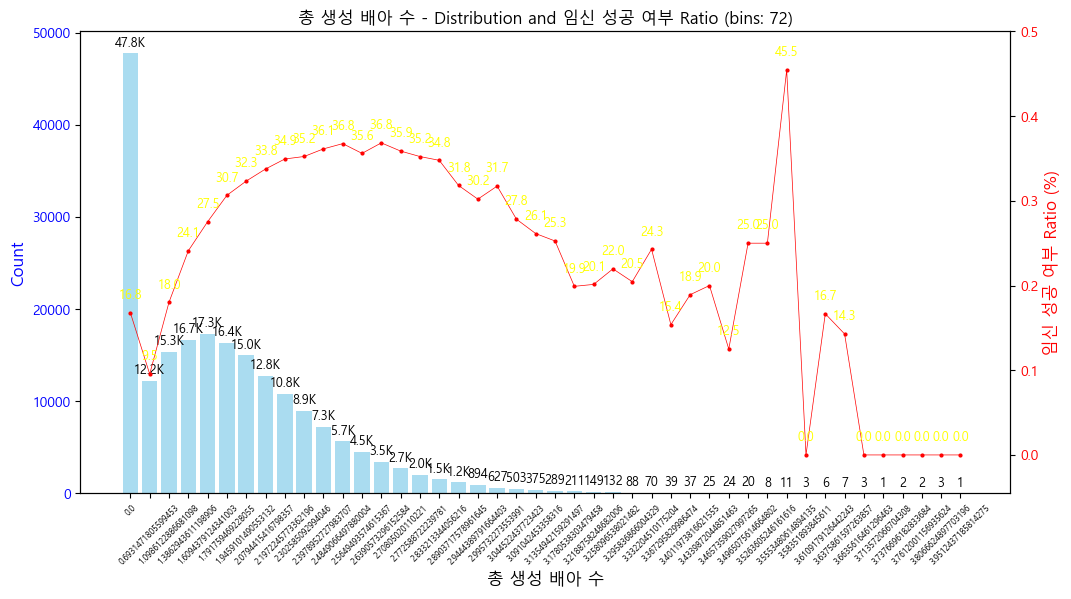

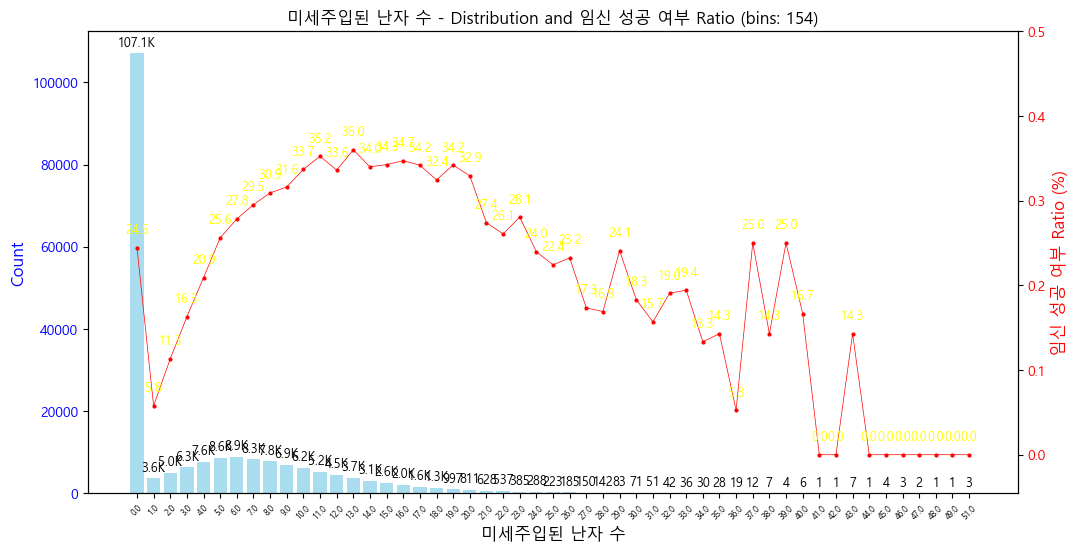

In [8]:
cols = [
    'Ï¥ù ÏÉùÏÑ± Î∞∞ÏïÑ Ïàò',
    'ÎØ∏ÏÑ∏Ï£ºÏûÖÎêú ÎÇúÏûê Ïàò'
]

visualize_continuous_with_target(train, cols, target_column='ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä')

In [8]:
# Ïã§Ìóò ÎÇ¥Ïö©
experiment_desc = '''
NODE
'''

In [9]:
cat_cols = [col for col in train.columns if pd.api.types.is_categorical_dtype(train[col])]
numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
numeric_cols = [
    col for col in numeric_cols
    if col not in cat_cols and col != 'ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä'
]
print(f'Î≤îÏ£ºÌòï Î≥ÄÏàò: \n {cat_cols}')
print(f'ÏàòÏπòÌòï Î≥ÄÏàò: \n {numeric_cols}')


data_config = DataConfig(
    target=[
        "ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä"
    ],
    continuous_cols=numeric_cols,
    categorical_cols=cat_cols,
)

trainer_config = TrainerConfig(
    # auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=512,
    accumulate_grad_batches=1024,
    data_aware_init_batch_size=2000,
    auto_lr_find=True,
    max_epochs=100,
    accelerator='gpu',
    early_stopping='valid_loss',
    early_stopping_min_delta=0.001,
    early_stopping_mode='min',
    early_stopping_patience=3,
    checkpoints='valid_loss',
    checkpoints_path='saved_models',
    checkpoints_save_top_k=1,
    progress_bar='simple',
)
optimizer_config = OptimizerConfig()

Î≤îÏ£ºÌòï Î≥ÄÏàò: 
 ['ÏãúÏà† ÏãúÍ∏∞ ÏΩîÎìú', 'ÏãúÏà† ÎãπÏãú ÎÇòÏù¥', 'Î∞∞ÎûÄ Ïú†ÎèÑ Ïú†Ìòï', 'ÎÇúÏûê Ï∂úÏ≤ò', 'Ï†ïÏûê Ï∂úÏ≤ò', 'ÎÇúÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥', 'Ï†ïÏûê Í∏∞Ï¶ùÏûê ÎÇòÏù¥', 'ÏãúÏà†Ïú†Ìòï_ÌÜµÌï©']
ÏàòÏπòÌòï Î≥ÄÏàò: 
 ['ÏûÑÏã† ÏãúÎèÑ ÎòêÎäî ÎßàÏßÄÎßâ ÏûÑÏã† Í≤ΩÍ≥º Ïó∞Ïàò', 'Î∞∞ÎûÄ ÏûêÍ∑π Ïó¨Î∂Ä', 'Îã®Ïùº Î∞∞ÏïÑ Ïù¥Ïãù Ïó¨Î∂Ä', 'Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ Í≤ÄÏÇ¨ ÏÇ¨Ïö© Ïó¨Î∂Ä', 'Ï∞©ÏÉÅ Ï†Ñ Ïú†Ï†Ñ ÏßÑÎã® ÏÇ¨Ïö© Ïó¨Î∂Ä', 'ÎÇ®ÏÑ± Ï£º Î∂àÏûÑ ÏõêÏù∏', 'ÎÇ®ÏÑ± Î∂Ä Î∂àÏûÑ ÏõêÏù∏', 'Ïó¨ÏÑ± Ï£º Î∂àÏûÑ ÏõêÏù∏', 'Ïó¨ÏÑ± Î∂Ä Î∂àÏûÑ ÏõêÏù∏', 'Î∂ÄÎ∂Ä Ï£º Î∂àÏûÑ ÏõêÏù∏', 'Î∂ÄÎ∂Ä Î∂Ä Î∂àÏûÑ ÏõêÏù∏', 'Î∂àÎ™ÖÌôï Î∂àÏûÑ ÏõêÏù∏', 'Î∂àÏûÑ ÏõêÏù∏ - ÎÇúÍ¥Ä ÏßàÌôò', 'Î∂àÏûÑ ÏõêÏù∏ - ÎÇ®ÏÑ± ÏöîÏù∏', 'Î∂àÏûÑ ÏõêÏù∏ - Î∞∞ÎûÄ Ïû•Ïï†', 'Î∂àÏûÑ ÏõêÏù∏ - ÏûêÍ∂ÅÍ≤ΩÎ∂Ä Î¨∏Ï†ú', 'Î∂àÏûÑ ÏõêÏù∏ - ÏûêÍ∂ÅÎÇ¥ÎßâÏ¶ù', 'Î∂àÏûÑ ÏõêÏù∏ - Ï†ïÏûê ÎÜçÎèÑ', 'Î∂àÏûÑ ÏõêÏù∏ - Ï†ïÏûê Ïö¥ÎèôÏÑ±', 'Î∂àÏûÑ ÏõêÏù∏ - Ï†ïÏûê ÌòïÌÉú', 'ÌÅ¥Î¶¨Îãâ ÎÇ¥ Ï¥ù ÏãúÏà† ÌöüÏàò', 'IVF ÏãúÏà† ÌöüÏàò', 'DI ÏãúÏà† ÌöüÏàò', 'Ï¥ù ÏûÑÏã† ÌöüÏàò', 'IVF ÏûÑÏã† Ìö

In [11]:
n_splits = 5
# seed_list = [42, 333, 777, 2024, 77]
seed_list = [777]
all_auc = []
test_preds = []
is_first = True

for seed in seed_list:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    auc_scores = []
    fold_test_preds = []

    train = pd.read_csv(train_path).drop(columns=['ID'])
    test = pd.read_csv(test_path).drop(columns=['ID'])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä'])):
        fold_train, fold_valid = train.iloc[train_idx].copy().reset_index(drop=True), train.iloc[valid_idx].copy().reset_index(drop=True)
        fold_train2 = fold_train.copy()
        fold_test = test.copy()

        fold_train, fold_valid = all_process(fold_train, fold_valid)
        fold_train2, fold_test = all_process(fold_train2, fold_test)

        model_config = NodeConfig(
            task="classification",
            learning_rate=0.001,
            embedding_dims=None,
            embedding_dropout=0.0,
            num_layers=1,
            num_trees=2048,
            additional_tree_output_dim=3,
            depth=6,
            choice_function='entmax15',
            bin_function='entmoid15',
            max_features=None,
            input_dropout=0.0,
            seed=seed,
        )

        tabular_model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            optimizer_config=optimizer_config,
            trainer_config=trainer_config,
            verbose=True,
        )

        tabular_model.fit(train=fold_train, validation=fold_valid, seed=seed)

        valid_preds = tabular_model.predict(fold_valid).iloc[:, 1]
        fold_auc = roc_auc_score(fold_valid['ÏûÑÏã† ÏÑ±Í≥µ Ïó¨Î∂Ä'], valid_preds)

        auc_scores.append(fold_auc)
        test_pred = tabular_model.predict(fold_test).iloc[:, 1]
        fold_test_preds.append(test_pred)

    test_preds.append(np.mean(fold_test_preds, axis=0))

    # Í∞Å seedÎ≥Ñ ÌèâÍ∑† AUCÏôÄ ÌëúÏ§ÄÌé∏Ï∞® Ï∂úÎ†•
    seed_auc_mean = np.mean(auc_scores)
    seed_auc_std = np.std(auc_scores)
    all_auc.append(seed_auc_mean)
    print(f"Seed {seed} - Average AUC: {seed_auc_mean:.5f} (STD: {seed_auc_std:.5f})")
    print('=' * 60)



# Ï†ÑÏ≤¥ Í≤∞Í≥ºÏóê ÎåÄÌïú ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞® Ï∂úÎ†•
total_auc_mean = np.mean(all_auc)
total_auc_std = np.std(all_auc)
print('-' * 60)
print(f'Total Average AUC: {total_auc_mean:.6f} (STD: {total_auc_std:.6f})')

2025-03-15 05:56:16,396 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 777


2025-03-15 05:56:16,417 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-03-15 05:56:16,574 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-03-15 05:56:17,204 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: NODEModel

2025-03-15 05:56:17,367 - {pytorch_tabular.models.node.node_model:74} - INFO - Data Aware Initialization of NODE   
using a forward pass with 2000 batch size....

2025-03-15 05:56:22,679 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-15 05:56:22,727 - {pytorch_tabular.tabular_model:656} - INFO - Auto LR Find Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [23]:
old_auc = 0.744533 * 100
old_std = 0.001171 * 100

new_auc = total_auc_mean * 100
new_std = total_auc_std * 100

def calculate_change(old_value, new_value):
    change = new_value - old_value
    percentage_change = (change / old_value) * 100 if old_value != 0 else float('inf')
    return change, percentage_change

def format_change(change):
    return f"{change:+.6f}"

# Í∞Å ÏßÄÌëúÏùò Î≥ÄÌôîÎüâ Í≥ÑÏÇ∞
auc_change, auc_pct = calculate_change(old_auc, new_auc)
std_change, std_pct = calculate_change(old_std, new_std)

# Í≤∞Í≥º Ï∂úÎ†•
print("\n========== Î™®Îç∏ ÏÑ±Îä• Î≥ÄÌôî ==========")
print(f"{'Metric':<8}  {'AUC':>12}  {'Acc':>12}")
print("-" * 36)
print(f"{'Old':<8}  {old_auc:>12.6f}  {old_std:>12.6f}")
print(f"{'New':<8}  {new_auc:>12.6f}  {new_std:>12.6f}")
print(f"{'Change':<8}  {format_change(auc_change):>12}  {format_change(std_change):>12}")
print(f"{'% Change':<8}  {auc_pct:>11.4f}%  {std_pct:>11.4f}%")
print("=" * 36)


========== Î™®Îç∏ ÏÑ±Îä• Î≥ÄÌôî ==========
Metric             AUC           Acc
------------------------------------
Old          74.453300      0.117100
New          73.985216      0.000000
Change       -0.468084     -0.117100
% Change      -0.6287%    -100.0000%


In [24]:
sample_submission = pd.read_csv(sample_path)
sample_submission['Ï±ÑÎ¨¥ Î∂àÏù¥Ìñâ ÌôïÎ•†'] = np.mean(test_preds, axis=0)

ratio = train['Ï±ÑÎ¨¥ Î∂àÏù¥Ìñâ Ïó¨Î∂Ä'].value_counts(normalize=True)[1]
real_true_count = int(ratio * len(sample_submission))
print(f'testÏùò True Í∞ØÏàò: {real_true_count:<5} (Ï∂îÏ†ï)')

count = (sample_submission['Ï±ÑÎ¨¥ Î∂àÏù¥Ìñâ ÌôïÎ•†'] >= 0.5).sum()
print(f'testÏùò True Í∞ØÏàò: {count:<5} (ÏòàÏ∏° Í≤∞Í≥º)')

testÏùò True Í∞ØÏàò: 703   (Ï∂îÏ†ï)
testÏùò True Í∞ØÏàò: 238   (ÏòàÏ∏° Í≤∞Í≥º)


In [25]:
now = datetime.datetime.now().strftime("%m%d_%H%M")

In [26]:
submission_path = 'Submission'
if not os.path.exists(submission_path):
    os.makedirs(submission_path)

code_dir = 'Code'
if not os.path.exists(code_dir):
    os.makedirs(code_dir)

submission_name = f"submission_{now}.csv"
new_notebook_name = f"code_{now}.ipynb"

sample_submission.to_csv(os.path.join(submission_path, submission_name), encoding='UTF-8-sig', index=False)

current_notebook = ipynbname.path()
new_notebook_path = os.path.join(code_dir, new_notebook_name)
shutil.copy(current_notebook, new_notebook_path)

print(f"Notebook saved in '{code_dir}' as '{new_notebook_name}'")

Notebook saved in 'Code' as 'code_0311_2305.ipynb'


In [27]:
# üìå SQLite Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ ÏÑ§Ï†ï
db_path = "lgbm_experiment_results.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# üìå ÌÖåÏù¥Î∏î ÏÉùÏÑ± (Ï≤òÏùå Ïã§Ìñâ Ïãú)
cursor.execute('''
CREATE TABLE IF NOT EXISTS experiments (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    code_name TEXT,
    experiment_desc TEXT,
    auc REAL,
    std REAL
)
''')

In [28]:
# Îç∞Ïù¥ÌÑ∞ ÏÇΩÏûÖ
cursor.execute('''
INSERT INTO experiments (code_name, experiment_desc, auc, std)
VALUES (?, ?, ?, ?)
''', (new_notebook_name, experiment_desc.strip(), new_auc, new_std))

# Î≥ÄÍ≤ΩÏÇ¨Ìï≠ Ï†ÄÏû• & Ïó∞Í≤∞ Ï¢ÖÎ£å
conn.commit()
conn.close()

print(f"Experiment '{new_notebook_name}' successfully saved in database")

Experiment 'code_0311_2305.ipynb' successfully saved in database


In [29]:
import sqlite3
import pandas as pd

# SQLite Îç∞Ïù¥ÌÑ∞ Ï°∞Ìöå Ìï®Ïàò
def get_experiment_results(db_path="lgbm_experiment_results.db", num_results=10):
    """
    SQLite Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ÏóêÏÑú Ï§ëÎ≥µÎêú Ïã§Ìóò Îç∞Ïù¥ÌÑ∞Î•º Ï†úÍ±∞ÌïòÍ≥†, ÏµúÍ∑º num_resultsÍ∞úÏùò Ïã§Ìóò Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò§Îäî Ìï®Ïàò.
    Returns:
        - Pandas DataFrame: Ï§ëÎ≥µ Ï†úÍ±∞Îêú Ïã§Ìóò Îç∞Ïù¥ÌÑ∞
    """
    conn = sqlite3.connect(db_path)

    # Ï§ëÎ≥µ Ï†úÍ±∞ & ÏµúÏã† Îç∞Ïù¥ÌÑ∞ ÏÑ†ÌÉùÌïòÎäî SQL ÏøºÎ¶¨
    query = f"""
    SELECT * FROM experiments
    WHERE id IN (
        SELECT MAX(id)  -- Í∞ÄÏû• ÏµúÏã† Îç∞Ïù¥ÌÑ∞ ÏÑ†ÌÉù
        FROM experiments
        GROUP BY code_name -- id Ï†úÏô∏ÌïòÍ≥† Ï§ëÎ≥µ ÌåêÎã®
    )
    ORDER BY id DESC  -- ÏµúÏã† Îç∞Ïù¥ÌÑ∞Î∂ÄÌÑ∞ Ï†ïÎ†¨
    LIMIT {num_results};
    """

    df = pd.read_sql_query(query, conn)
    conn.close()

    return df


df_results = get_experiment_results(num_results=100)
df_results.to_csv('lgbm_experiment_results.csv', index=False, encoding='utf-8-sig', float_format='%.4f')
df_results

id             code_name                      experiment_desc        auc  \
0   31  code_0311_2305.ipynb                                 NODE  73.985216   
1   30  code_0311_2246.ipynb                                 NODE  73.985216   
2   29  code_0311_2219.ipynb                                 NODE  73.816734   
3   28  code_0311_2039.ipynb                                 NODE  68.368928   
4   27  code_0310_2158.ipynb                               TabPFN  74.776633   
5   26  code_0310_0048.ipynb                               TabPFN  74.792289   
6   25  code_0309_2215.ipynb                               TabPFN  74.813522   
7   24  code_0309_2212.ipynb                               TabPFN  74.873422   
8   23  code_0306_2055.ipynb  ÏÉòÌîåÎßÅ, ÏãúÎìú777, Ï∫£Î∂ÄÏä§Ìä∏, ÏÉòÌîå 200Í∞ú, Ïª¨Îüº ÎûúÎç§ ÏÑ†ÌÉù  74.588855   
9   22  code_0306_1946.ipynb  ÏÉòÌîåÎßÅ, ÏãúÎìú777, Ï∫£Î∂ÄÏä§Ìä∏, ÏÉòÌîå 200Í∞ú, Ïª¨Îüº 8Í∞ú Í≥†Ï†ï  71.412381   
10  21  code_0306_0854.ipynb            ÏÉòÌîåÎßÅ, ÏãúÎìú777, Ï∫£Î∂ÄÏä§Ìä∏, ÏÉòÌîå 500Í∞ú  74.686743   
11  20  code_0306_0735.ipynb                     ÏÉòÌîåÎßÅ, ÏãúÎìú777, lgbm  74.567306   
12  19  code_0304_0741.ipynb                        ÏãúÎìú ÏïôÏÉÅÎ∏î(Í∞ÅÍ∞Å ÌäúÎãù)  75.071860   
13  18  code_0304_0739.ipynb           ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning2  75.107780   
14  17  code_0304_0653.ipynb           ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning2  75.017522   
15  16  code_0304_0640.ipynb           ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning2  74.948905   
16  14  code_0304_0614.ipynb           ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning2  74.994350   
17  13  code_0304_0504.ipynb           ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning2  75.090279   
18  12  code_0304_0500.ipynb           ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning2  74.862140   
19  11  code_0304_0437.ipynb           ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning2  74.903975   
20  10  code_0304_0344.ipynb            ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning, tunning  75.051732   
21   9  code_0304_0342.ipynb                     ÌòÑÏû¨ÏßÅÏû•Í∑ºÏÜçÏó∞Ïàò binning  74.453337   
22   8  code_0303_1223.ipynb           Loan_to_Income_Ratio, k=10  74.376082   
23   6  code_0303_1219.ipynb                     ÏãúÍ∞ÑÎãπ_Í∞úÏù∏ÌååÏÇ∞ÌöüÏàò, k=20  74.526327   
24   5  code_0303_1218.ipynb                     ÏãúÍ∞ÑÎãπ_Í∞úÏù∏ÌååÏÇ∞ÌöüÏàò, k=15  74.449887   
25   4  code_0303_1212.ipynb              ÏãúÍ∞ÑÎãπ_Í∞úÏù∏ÌååÏÇ∞ÌöüÏàò(train, test)  74.404942   
26   3  code_0303_1211.ipynb              ÏãúÍ∞ÑÎãπ_ÏÑ∏Í∏àÏïïÎ•òÌöüÏàò(train, test)  74.307858   
27   2  code_0303_1209.ipynb    Loan_to_Income_Ratio(train, test)  74.376082   
28   1  code_0303_1204.ipynb     [LGBM] Í∏∞Î≥∏, seed 42,333,777, 2024  74.312974   

         std  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4   0.000000  
5   0.000000  
6   0.000000  
7   0.033450  
8   0.000000  
9   0.000000  
10  0.000000  
11  0.000000  
12  0.039081  
13  0.000000  
14  0.000000  
15  0.000000  
16  0.000000  
17  0.000000  
18  0.000000  
19  0.086895  
20  0.068224  
21  0.117068  
22  1.947253  
23  2.565628  
24  2.223170  
25  1.822866  
26  1.874997  
27  1.947253  
28  1.935063